<a href="http://landlab.github.io"><img style="float: left" src="../../landlab_header.png"></a>

# Introduction to the SpeciesEvolver component
<hr>

The links between the evolution of life and landscapes can be explored with SpeciesEvolver. This component tracks and evolves `Taxon` objects populated within a model grid. `Taxon` objects can represent species and other taxonomic levels.

In this tutorial we will build and run a model that exemplifies SpeciesEvolver functionality. You will have the opportunity to
* Populate a model grid with taxa.
* Evolve taxa in response to climate change.
* View the SpeciesEvolver record that stores model variables over time.
* Plot some model output.

This tutorial demonstrates the default, simplest capabilities of SpeciesEvolver. See the documentation for information upon other capabilities, including subclassing the ``Taxon`` class, enabling you to design different approaches to landscape-life evolution modeling.

For simpicity, the model we will construct uses only one Landlab process component: SpeciesEvolver. This component, as other Landlab components, are intended to be coupled for dynamic modeling of surface processes.

## Example model: climate change impacts on taxa distribution and evolution

### Premise

Ecosystems zonate by elevation in large part because surface air temperature decreases with altitude. Long term temperature change alters the landscape connectivity within elevations zones, and connectivity affects gene flow, leading to the question: ***How is vegetation macroevolution impacted by temperature changes?***

### Approach

We model the macroevolutionary processes of taxa in response to temperature change. The type of taxa is described as vegetation species in the text of this notebook. Although, nothing in the code designates the taxa as vegetation or as a species taxonomic level.

The model progresses in terms of time steps with an unprescribed duration. Initial conditions are set in time 0. The initial topography is loaded from a previously run model and does not change for the duration of the model in this notebook. Note that SpeciesEvolver can be used with a prescribed irregular or regular time step duration, e.g. a number of years.

In this model, air surface temperature at each time step is set by elevation using a lapse rate, the decrease of temperature with elevation. The temperature at base level in time 0 is 26&deg;C. The temperature throughout the grid is calculated using the base level temperature and the lapse rate. The temperature is decreased by 5&deg;C in both times 1 and 2.

At each time step, species distribution is set only by temperature, for simplicity of demonstration. The change in connectivity of species populations drive macroevolutionary processes built into the programmed species.

SpeciesEvolver is built to be adapted for many model approaches, especially for different taxon properties and behaviors. We will use `ZoneTaxon` in this notebook. This `Taxon` type is distributed with SpeciesEvolver and relies on `Zone` objects to evaluate evolutionary processes. The macroevolutionary processes built into `ZoneTaxon` are
* dispersal: movement of a taxon from one area to another
* speciation: production of child taxa by parent taxa
* extinction: end of taxa existence

In this model, the geographic range of species exists with the temperatures, 18&deg;C and 24&deg;C inclusive, meaning the extent of zones is bounded by this interval at each time step, and all species exist only within these temperatures at each time step.

Also in this model, speciation is simulated only as allopatric speciation that occurs as populations of a taxon become geographically isolated. Speciation triggered not by geographic isolation (sympatric speciation) is not modeled here, although it can be readily implemented by extending the speciation method of `ZoneTaxon` (see the documentation of this class).

### Summary

In this model, we

* Set surface air temperture across a model grid as a function of elevation.
* Populate species within the grid. These species exist within a fixed temperature interval.
* Simulate three time steps where surface air temperature changes in the latter two steps, which drives species response to this change.
* Examine how the number of species, *i.e.* "taxa richness" changes as the model progresses.

## Import modules

The zones of `ZoneTaxon` are managed by a `ZoneController`, so we must import this class along with the SpeciesEvolver component and the other modules used in this notebook.

In [1]:
from landlab.components import SpeciesEvolver, Profiler
from landlab.components.species_evolution import ZoneController
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

## Prepare the grid

### Load topography

Here the topography of the model grid is loaded from a file. The topography was previously developed using a model built with Landlab. An initial surface was uplifted, stream erosion was conducted using the FastscapeEroder component, and hillslope diffusion was conducted using the LinearDiffuser component. The model was run until topography reached steady state.

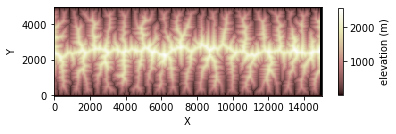

In [2]:
# Create a model grid and set a topographic elevation field.
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z

# Set the top and bottom grid boundaries to open.
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

# Plot the elevation field.
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)', shrink=0.4)

### Create a grid field of air temperature at the land surface

We set a surface air temperature at base level (upper and lower boundaries). We use a lapse rate to create a  surface air temperature field at all nodes of the grid. The lapse rate, *L* is modeled as the decrease of temperature, *T* with increasing elevation, *z* as

\begin{align*}
L = -\frac{\delta t}{\delta z}
\end{align*}

We use a constant lapse rate of -5&deg;C / km.

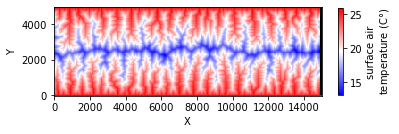

In [3]:
# Set a rate of temperature decrease per meter of elevation increase.
lapse_rate = -0.005

# Create a surface air temperature field.
temperature_at_base_level = 26
T = lapse_rate * z + temperature_at_base_level
mg.add_field('node', 'land_surface_air__temperature', T)

# Plot temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4,
    cmap='bwr'
)

## Setup SpeciesEvolver and zones

The general workflow of working with zones and zone-based taxa is

* Initialize the SpeciesEvolver component.
* Setup zones and zone-based taxa:
    * Define a function that identifies the grid nodes where all zones will be created.
    * Initialize a ZoneController that will create and manage zones.
    * Populate zones with taxa.
* Introduce species to SpeciesEvolver so the component will track them over time.

### Initialize SpeciesEvolver

This component requires only one parameter, a model grid.

In [4]:
se = SpeciesEvolver(mg)

View `record_data_frame` of our SpeciesEvolver instance. Time and other model variables are stored in this attribute that is a Pandas DataFrame. The first and second columns are the row number and model time, respectively. In the third column we see that 0 taxa exist. We have yet to introduce taxa.

In [5]:
se.record_data_frame

,time,taxa
0,0,0


### About zones

Zones help to evaluate the spatial aspect of `ZoneTaxon` macroevolutionary processes. A zone represents a portion of a model grid. It is made up of spatially continuous grid nodes. Along with SpeciesEvolver, zones can be utilized to track habitats or potential taxa geographic extents over time. In this notebook, zones will be created at each time step where temperature is within the suitable temperature range of the vegetation species. Multiple zones will be created at time steps if grid nodes with suitable temperature are not spatially continuous.

At each time step, the spatial connectivity of the zones between the current (*t*) and prior (*t*-1) time steps are identified. For example, consider two consecutive time steps where a zone in the prior time intersects two zones in the current time. This type of connection in the zones of SpeciesEvolver is referred to as 'one-to-many' represented here

<img src="./img/zone_connectivity__one_to_many.svg" width="40" height="40" /> 

where the red arrows represent zone connectivity over time, and

<img style="float: left;" src="./img/zone__prior_time.svg" width="20" height="20" /> &nbsp; a zone in *t*-1, the time step preceeding *t*

<img style="float: left;" src="./img/zone__current_time.svg" width="20" height="20" /> &nbsp; a zone in *t*, the current time step<br><br>


Behind the scenes, macroevolutionary rules programmed into `ZoneTaxon` are evaluated considering the type of zone connectivity. The outcome of the rules given the connectivity type are described in the table below.

<center>connectivity<br>type</center> | <center>graphical<br>represention</center> | <center>connectivity description</center> | <center>macroevolution implications</center>
--- | --- | --- | ---
one-to-none | <img src="./img/zone__prior_time.svg" width="20" height="20" />  | a zone in *t*-1 does not intersect a zone in *t*. | The taxa in the zone of the prior time will become extinct. 
one-to-one | <img src="./img/zone__one_to_one.svg" width="30" height="30" /> | a zone in *t*-1 intersects a zone in *t*. | The taxa in the zone of the prior time moves along with the zone of the current time. This connectivity type also occurs where a zone of the prior time does not relocate in the current time.
one-to-many | <img src="./img/zone__one_to_many.svg" width="30" height="30" /> | a zone in *t*-1 intersects multiple zones in *t*. | The taxa in the zone of the prior time disperses across the multiple zones in the current time. The taxa in the zones of the current time are geographically disconnected, thus speciation is triggered.
many-to-one | <img src="./img/zone__many_to_one.svg" width="30" height="30" /> | Multiple zones in *t*-1 intersect a zone in *t*. | The taxa in the prior time zones are relocated to a zone in the current time. Taxa density increases if zone<sub>*t*</sub> is smaller than the prior time step zones combined.
many-to-many | <img src="./img/zone__many_to_many.svg" width="40" height="40" /> | Multiple zones in *t*-1 intersect multiple zones in *t*. | The taxa in connected zones of *t*-1 relocates to the connected zones in *t*. Speciation is triggered for the taxa extant at the prior time step because their range becomes fragmented in the current time step.

Attributes of a zone include `mask` that indicates where in the grid the zone exists and `taxa`, which are the extant `Taxon` objects within the zone.

In [6]:
def zone_func(grid):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_max = 25
    T_min = 18
    zone_extent_mask = np.all([T >= T_min, T <= T_max], 0)
    return zone_extent_mask

To demonstrate the output of this function, `True` values are shaded white in the plot below. Zones will be created in the masked area (in white). Later we will see that two zones are created, one for each cluster of `True` values.

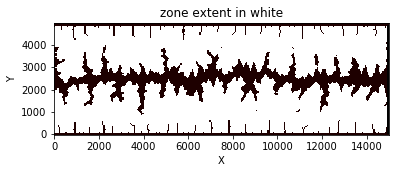

In [7]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False, plot_name='zone extent in white')

### Initialize ZoneController

Next, we instantiate a ZoneController that will create and manage the zones. We used an optional parameter, `minimum_area` to indicate the minimum area of the zones to be created. Zones will be created upon initialization of this controller.

In [8]:
zc = ZoneController(mg, zone_func, minimum_area=50000)

Above, the mask returned by the `zone_func` indicates where zones should be created.

Below, we see ZoneController created two zones designated by the different colors, one for each spatially distinct node cluster in the `zone_func` mask.

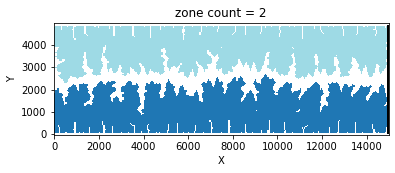

In [9]:
# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
cmap = plt.cm.tab20
cmap.set_under('w')
title = 'zone count = {}'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=1)

Multiple instances of ZoneController may be used with the same instance of SpeciesEvolver. This is useful when you wish to model groups of taxa within the same grid where each group needs a different zone function, for instance, fish and bears.

### Plot initial profile

Species dispersal at each time step will be considered by plotting the zone temperature interval alongside a topographic profile.

This initial profile is plotted across the main west-east divide.

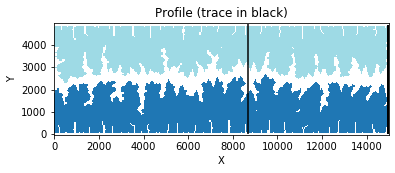

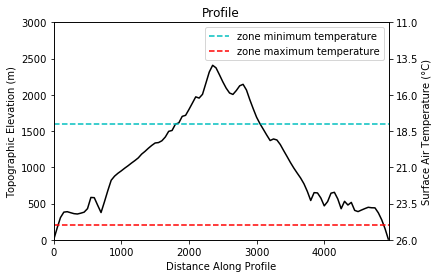

In [10]:
# Plot profile in map view.

endpoints = [29874, 174]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='k', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name='Profile (trace in black)', vmin=1
)

# Plot profile.

fig, ax0 = plt.subplots()
profiler.plot_profiles(
    ylabel='Topographic Elevation (m)',
    color='k',
    title='Profile')
ax0.set_ylim([0, 3000])

ax1 = ax0.twinx()
ax1.set_ylim(ax0.get_ylim())
ax1.set_yticklabels(lapse_rate * ax0.get_yticks() + temperature_at_base_level)
ax1.set_ylabel('Surface Air Temperature (\N{DEGREE SIGN}C)')

# Include species temperature bounds.

upper = (18 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [upper, upper], 'c--', label='zone minimum temperature')

lower = (25 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [lower, lower], 'r--', label='zone maximum temperature')

ax0.legend();

The profile (north is on the left) also illustrates that the two zones are seperated by the area around the main divide. This area is below the minimum zone temperature, therefore the ZoneController excluded zone creation here.

### Seed zones with taxa

A taxa is populated to each of the two initial zones using the ZoneController method, `populate_zones_uniformly`. This method creates species and populates it to each zone. (Any number of taxa can be populated to zones, and zones can be populated with different numbers of species.)

In [11]:
taxa = zc.populate_zones_uniformly(1)

### Introduce taxa to SpeciesEvolver

All taxa must be introduced using the SpeciesEvolver method, `track_taxa` in order for the taxa to be tracked by SpeciesEvolver.

In [12]:
se.track_taxa(taxa)

Two taxa now exist in SpeciesEvolver. In this notebook, each represents a vegetation species. In this model, nothing specific to vegetation species is needed, beyond setting the zone extent by air temperature using the zone function, thus the built functionality of ``ZoneTaxon`` is sufficient.

In [13]:
se.record_data_frame

,time,taxa
0,0,2


The SpeciesEvolver attribute, `taxa_data_frame` provides data about all of the tracked taxa, both extant and extinct. The data is presented in a Pandas DataFrame. Each row is data about a taxon.

In [14]:
se.taxa_data_frame

,pid,type,t_first,t_final
tid,,,,
0,<NA>,ZoneTaxon,0,<NA>
1,<NA>,ZoneTaxon,0,<NA>


`tid` is the identifier used to reference and retrieve ``Taxon`` objects, demostrated later in this notebook. Taxa are assigned identifiers in the order they are introduced to SpeciesEvolver.

`pid` is the identifier of the parent taxon. The parent of a taxon is the object that produced it. `<NA>` indicates no parent, which is typically the case of the model founder taxa.

`type` is the type of Taxon object.

`t_first` is the model time when the taxon emerged.

`t_final` is the final time of the taxon and when it was recognized as extinct. `<NA>` indicates a taxon is extant at the current model time.

## Model time step 1

Initial conditions were established in time 0. Next, climate change is modeled by increasing the temperature at base level by 5&deg;C.

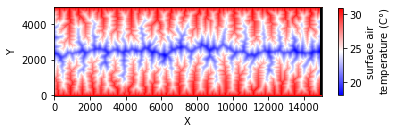

In [15]:
# Update the temperature field.
temperature_at_base_level += 5
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot the temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4, cmap='bwr'
)

Here we advance ZoneController and SpeciesEvolver in time by one time step. ZoneController is advanced first in order to update the zones prior to calling SpeciesEvolver.

`dt` is set to 1 only because the duration of a time step is not prescribed in this tutorial. This `1` does not signify that one time step is run. We use 1 herein to make it easy to think about the time step sequence. Often, you may wish to make `dt` be the number of years in a time step, especially when you are running surface processes components alongside SpeciesEvolver.

In [16]:
dt = 1
zc.run_one_step(dt)
se.run_one_step(dt)

One zone now exists because the temperature increase raised the area that falls within the temperature range prescribed in `zone_func`.

Plot the zones.

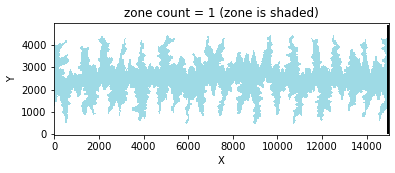

In [17]:
# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
title = 'zone count = {} (zone is shaded)'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=0.5)

A 'many-to-one' zone connectivity occurred in this time step relative to the previous time step, meaning neither speciation or extinction were triggered by zone change. (See zone connectivity table above.)

The same two taxa of time 0 exist in time 1. Their geographic range is all that changed.

In [18]:
se.taxa_data_frame

,pid,type,t_first,t_final
tid,,,,
0,<NA>,ZoneTaxon,0,<NA>
1,<NA>,ZoneTaxon,0,<NA>


### Plot a profile across the main divide

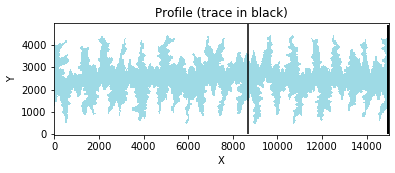

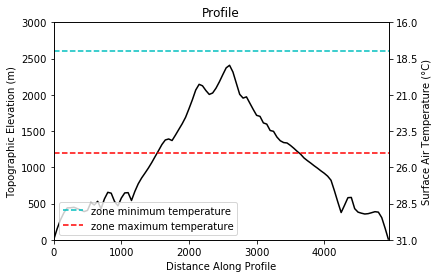

In [19]:
# Plot profile in map view.

endpoints = [174, 29874]
profiler = Profiler(mg, endpoints)
profiler.run_one_step()
profiler.plot_profiles_in_map_view(
    color='k', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name='Profile (trace in black)', vmin=0.5
)

# Plot profile.

fig, ax0 = plt.subplots()
profiler.plot_profiles(
    ylabel='Topographic Elevation (m)',
    color='k',
    title='Profile')
ax0.set_ylim([0, 3000])

ax1 = ax0.twinx()
ax1.set_ylim(ax0.get_ylim())
ax1.set_yticklabels(lapse_rate * ax0.get_yticks() + temperature_at_base_level)
ax1.set_ylabel('Surface Air Temperature (\N{DEGREE SIGN}C)')

# Include species temperature bounds.

upper = (18 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [upper, upper], 'c--', label='zone minimum temperature')

lower = (25 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 5000], [lower, lower], 'r--', label='zone maximum temperature')

ax0.legend();

Species were able to cross the main divide following the temperature increase. The two species now exist in the same area along the main divide. Coexisting has no effect because ZoneTaxon do not interact in the default implemention of the code for this species, although species can be made to influence each other by extending `ZoneTaxon` (see the documentation of this class).

## Model time step 2

Temperature is again increased by 5&deg;C in time step 2.

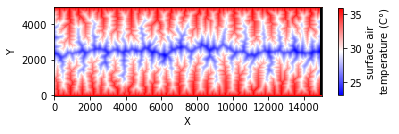

In [20]:
# Update the surface temperature field.
temperature_at_base_level += 5
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot temperature field.
imshow_grid(
    mg, 'land_surface_air__temperature',
    colorbar_label='surface air\ntemperature (C$\degree$)',
    shrink=0.4, cmap='bwr'
)

Advance ZoneController and SpeciesEvolver, and plot zones.

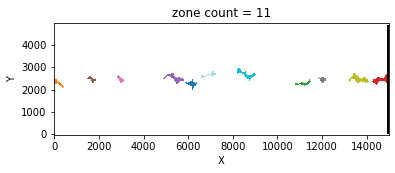

In [21]:
zc.run_one_step(dt)
se.run_one_step(dt)

# Create a map of all zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(zc.zones):
    zone_map[zone.mask] = i + 1

# Plot zone map.
title = 'zone count = {}'.format(len(zc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=0.5)

The grid now contains more zones than the prior time step. The macroevolutionary effect of this `one-to-many` zone connectivity relationship is examined in the next section.

## Examine model outcome

We see 22 extant taxa in the taxa DataFrame. We know all taxa are extant because `t_final` is `<NA>`. Taxon 0 is the parent of taxa 2...11. Taxon 1 is parent to taxa 12...21. The child taxa appeared at time 2 (see `t_first`) as temperature increased for the second time.

In [22]:
se.taxa_data_frame

,pid,type,t_first,t_final
tid,,,,
0,<NA>,ZoneTaxon,0,<NA>
1,<NA>,ZoneTaxon,0,<NA>
2,0,ZoneTaxon,2,<NA>
3,0,ZoneTaxon,2,<NA>
4,0,ZoneTaxon,2,<NA>
5,0,ZoneTaxon,2,<NA>
6,0,ZoneTaxon,2,<NA>
7,0,ZoneTaxon,2,<NA>
8,0,ZoneTaxon,2,<NA>


In the SpeciesEvolver record DataFrame, we see 20 speciations at time 2.

In [23]:
se.record_data_frame

,time,taxa,speciations,extinctions
0,0,2,NaN,NaN
1,1,2,0.0,0.0
2,2,22,20.0,0.0


Next we will examine the model history using the plot below

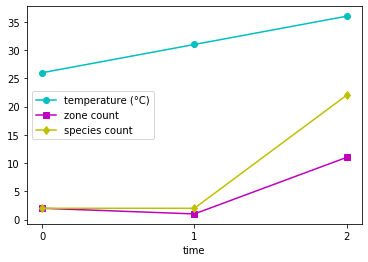

In [24]:
# Create a plot of key model variables over time.

time = se.record_data_frame.time
temperature = [26, 31, 36]
n_zones = zc.record_data_frame.zones
n_species = se.record_data_frame.taxa

plt.plot(time, temperature, 'o-c', label='temperature (\N{DEGREE SIGN}C)')
plt.plot(time, n_zones, 's-m', label='zone count')
plt.plot(time, se.record_data_frame.taxa, 'd-y', label='species count')
plt.xlabel('time')
plt.xticks(time)
plt.legend();

### Plot time 1 profile along the main divide

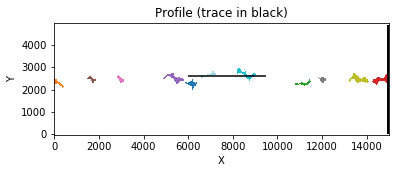

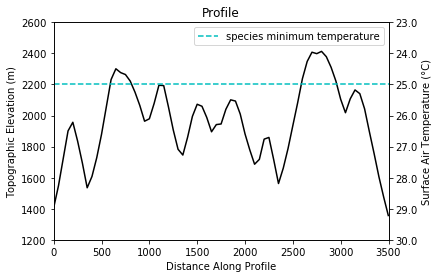

In [25]:
# Plot profile in map view.

endpoints = [15720, 15790]
profiler2 = Profiler(mg, endpoints)
profiler2.run_one_step()
profiler2.plot_profiles_in_map_view(
    color='k', field=zone_map, cmap=cmap,
    allow_colorbar=False, plot_name='Profile (trace in black)', vmin=1
)

# Plot profile.

fig, ax0 = plt.subplots()
profiler2.plot_profiles(
    ylabel='Topographic Elevation (m)',
    color='k',
    title='Profile')
ax0.axis(ymin=1200, ymax=2600)

ax1 = ax0.twinx()
ax1.set_ylim(ax0.get_ylim())
ax1.set_yticklabels(lapse_rate * ax0.get_yticks() + temperature_at_base_level)
ax1.set_ylabel('Surface Air Temperature (\N{DEGREE SIGN}C)')

# Include species min elevation line.

z_min = (25 - temperature_at_base_level) / lapse_rate
ax0.plot([0, 3500], [z_min, z_min], 'c--', label='species minimum temperature')
ax0.legend();

The profile trace crosses two zones (upper figure). The topography is above the elevation with the minimum species temperature for these two zones (lower figure).

An additional increase in temperature drove species to become isolated on mountain peaks along the main divide. Species could not reach adjacent peaks because valleys were too warm. Each peak that was below the maximum species temperature led to an isolated population that produced a child species. In the model we ran, 11 peaks/divide areas met these qualifications, thus species 0 and 1 produced 10 child species each. The original population of each founding species remained in one zone. Child taxa populated the other 10 zones.

## Examine the species

SpeciesEvolver automatically creates a `taxa__richness` grid field. We can use this field to see that there are two species in each zone. (taxa richness = number of taxa). Each zone contains a founder or descendent species from each of the two founder species.

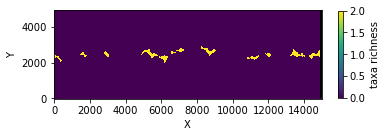

In [26]:
imshow_grid(
    mg, 'taxa__richness', colorbar_label='taxa richness',
    shrink=0.4, cmap='viridis'
)

Similar to SpeciesEvolver, ZoneController has a `record_data_frame` that stores model variables over time. The ZoneController stores variables pertinent to zones.

In the ZoneController record, 'fragmentation_count' in time 2 is 11. The one zone in time 1 split into 11 fragments, or zones, essentially between times 1 and 2.

We see capture statistics in this record as well. Here, a capture indicates that a zone captured area from a zone in a prior time step. The one zone in time 1 captured the two zones in time 0.

In [27]:
zc.record_data_frame

,time,zones,fragmentations,captures,area_captured_sum,area_captured_max
0,0,2,NaN,NaN,NaN,NaN
1,1,1,0.0,1.0,29340000.0,29340000.0
2,2,11,11.0,0.0,0.0,0.0


Pandas DataFrame methods can be used on `record_data_frame`. For example, here we get the maximum capture count.

In [28]:
zc.record_data_frame.zones.max()

11

### Retrieve taxon objects

Metadata of taxa can be viewed in `taxa_data_frame`, although taxon objects cannot be retrieved from this DataFrame. The objects of those taxa extant at the current model time can be retrieved using the SpeciesEvolver method, `get_extant_taxon_objects`. With a `Taxon` object you can examine its current properties, including plotting its geographic range as demonstrated below.

All of the extant taxa are returned when no parameters are inputted into `get_taxon_objects`.

In [29]:
se.get_extant_taxon_objects()

[<ZoneTaxon, tid=0>,
 <ZoneTaxon, tid=1>,
 <ZoneTaxon, tid=2>,
 <ZoneTaxon, tid=3>,
 <ZoneTaxon, tid=4>,
 <ZoneTaxon, tid=5>,
 <ZoneTaxon, tid=6>,
 <ZoneTaxon, tid=7>,
 <ZoneTaxon, tid=8>,
 <ZoneTaxon, tid=9>,
 <ZoneTaxon, tid=10>,
 <ZoneTaxon, tid=11>,
 <ZoneTaxon, tid=12>,
 <ZoneTaxon, tid=13>,
 <ZoneTaxon, tid=14>,
 <ZoneTaxon, tid=15>,
 <ZoneTaxon, tid=16>,
 <ZoneTaxon, tid=17>,
 <ZoneTaxon, tid=18>,
 <ZoneTaxon, tid=19>,
 <ZoneTaxon, tid=20>,
 <ZoneTaxon, tid=21>]

The taxa can be filtered by the time they existed. To do so, we can use the optional parameter, `time` to indicate we want the taxa extant at time 0, the two taxa introduced at the beginning of the model.

In [30]:
se.get_extant_taxon_objects(time=0)

[<ZoneTaxon, tid=0>, <ZoneTaxon, tid=1>]

Get taxa by their identifier using the  `tid` parameter. Here we request only one taxon, the one with a tid of 12. This method always returns a list so we index the first and only element in this list.

In [31]:
taxon_12 = se.get_extant_taxon_objects(tids=[12])[0]
taxon_12

<ZoneTaxon, tid=12>

With a taxon object retrieved, we can work with it as we need. Here we plot its geographic range. The `range_mask` attribute of a taxon is a mask of its geographic range.

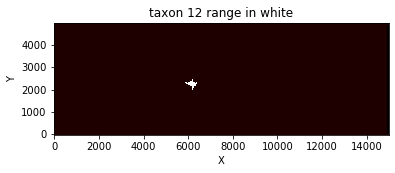

In [32]:
mask = taxon_12.range_mask
imshow_grid(mg, mask, plot_name='taxon 12 range in white', allow_colorbar=False)

The taxa with a common ancestor can be retrieved with the `ancestor` parameter. Here we get the taxa that descended from taxon 0 and then print only the identifiers of these descendents.

In [33]:
filtered_taxa = se.get_extant_taxon_objects(ancestor=0)
[t.tid for t in filtered_taxa]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

Taxon 0 is one of the initial taxa and speciated taxa 2...11 when the zone fragmented at time 2. The same sequence of events occurred for taxon 1 and its descendents, 12...21. This phylogeny is explained by the one zone capture that brought together the two initial taxa, followed by the 11 zones fragmentations that drove the 20 speciations of the child taxa descended from the two initial taxa.

### Click here for more [Landlab tutorials](https://landlab.readthedocs.io/en/latest/user_guide/tutorials.html)